<a href="https://colab.research.google.com/github/esamalqudah/CNN_CIFAR_10/blob/main/GANs_MNIST_(10).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Setup, load, and prepare the dataset

In [ ]:
!pip install imageio
!pip install git+https://github.com/tensorflow/docs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-mbcdl63s
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-mbcdl63s
  Resolved https://github.com/tensorflow/docs to commit 0c78d6d8ad6ced9178a081d41ead24ae80d88958
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0.dev0-py3-none-any.whl size=183245 sha256=2468294aff0bf31427b65d6f687110461fd148e95f3bb78cf0d0adadc5c194fa
  Stored in directory: /tmp/pip-ephem-wheel-cache-a78vcyn9/wheels/fc/f8/3b/5d21409a59cb1be9b1ade11f682039ced75b84de9dd6a0c8de
Successfully built tensorflow-docs


In [ ]:
import tensorflow as tf

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

## Load and prepare dataset

GAN will be trained using the MNIST dataset. The goal is to generate handwritten images similar to those in said dataset.



In [ ]:
#Download MNIST
(train_images, train_lables), (_, _) = tf.keras.datasets.mnist.load_data()

#Reshape and normalize
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5

#Set batch and buffer size
BUFFER_SIZE = 60000
BATCH_SIZE = 256

#Batch and shuffle data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)


11490434/11490434 [==============================] - 1s 0us/step


##Define our Generator Model

Both generator and discriminator to be defined using the Keras Sequential API.

The generator uses `tf.keras.layers.Conv2DTranspose` (upsampling) layers to produce an image from a seed (random noise). A `Dense` layer takes this seed as input, then upsamples several times until the desired image size of 28x28x1 is reached.

In [ ]:
from keras.api._v2.keras import activations
def make_generator_model():
  model = tf.keras.Sequential()
  model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Reshape((7, 7, 256)))
  assert model.output_shape == (None, 7, 7, 256)

  model.add(layers.Conv2DTranspose(128, (5,5), strides=(1,1), padding='same', use_bias=False))
  assert model.output_shape == (None, 7, 7, 128)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(64, (5,5), strides=(2,2), padding='same', use_bias=False))
  assert model.output_shape == (None, 14, 14, 64)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(1, (5,5), strides=(2,2), padding='same', use_bias=False, activation='tanh'))
  assert model.output_shape == (None, 28, 28, 1)

  return model


Test generator at making 28x28 grayscale images (like MNIST).

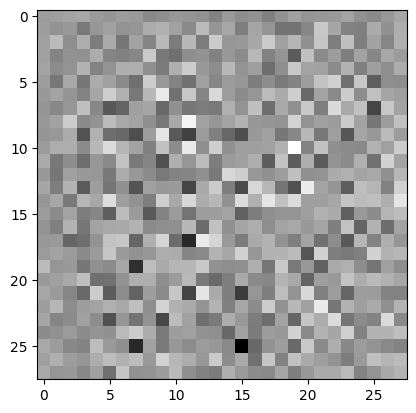

In [ ]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

##Define our Discriminator Model

The discriminator is a CNN-based image classifier.

In [ ]:
def make_discriminator_model():
  model = tf.keras.Sequential()
  model.add(layers.Conv2D(64, (5,5), strides=(2,2), padding='same',
                                  input_shape=[28, 28, 1]))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Conv2D(128, (5,5), strides=(2,2), padding='same'))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Flatten())
  model.add(layers.Dense(1))

  return model

Model to be trained to output positive values for real images, and negative values for fake images.

In [ ]:
discriminator = make_discriminator_model()

decision = discriminator(generated_image)
print(decision)

tf.Tensor([[-0.00230515]], shape=(1, 1), dtype=float32)


##Define the loss and optimizers

Define loss functions and optimizers for both models.


In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Discriminator loss

This method quantifies how well the discriminator is able to distinguish real images from fake ones. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.

In [ ]:
def discriminator_loss(real_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss
  return total_loss

### Generator loss
The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1).

In [ ]:
def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

### Save checkpoints


In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

##Define the training loop


In [ ]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16


seed = tf.random.normal([num_examples_to_generate, noise_dim])

Training loop begins with generator receiving a **random seed** as input.

Seed is used to produce an image.

Discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator).

Loss is calculated for each of these models, and gradients are used to update the generator and discriminator.

In [ ]:
@tf.function
def train_step(images):
  noise = tf.random.normal([BATCH_SIZE, noise_dim])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(noise, training=True)

    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)

  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

###Generate and save images


In [ ]:
def generate_and_save_images(model, epoch, test_input):


  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i+1)
    plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
    plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [ ]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

##Train model


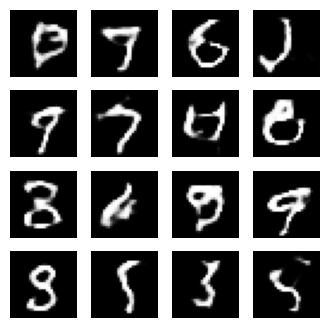

In [ ]:
train(train_dataset, EPOCHS)

Restore the latest checkpoint.

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## **7. Output - Let's create a GIF**


In [ ]:
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

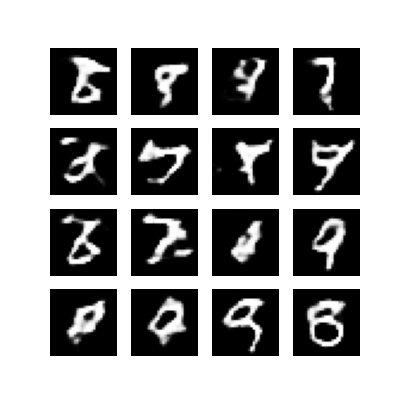

In [ ]:
display_image(EPOCHS)

Use `imageio` to create an animated gif using the images saved during training.

In [ ]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

<ipython-input-28-b2802a4e93ef>:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
<ipython-input-28-b2802a4e93ef>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)



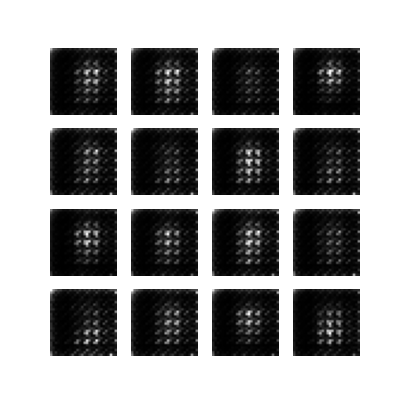

In [ ]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)